# FEniCS Nonlinear design of concrete bridge towers

Course MU5MES01

$\underline{\text{Students name}}$ : Valentin Duvivier & Marie Robin

$\underline{\text{Under the direction of}}$ : Corrado Maurini, Sebastien Neukirch, Denis Duhamel, Claire Lestringant
    
$\underline{\text{Last modified}}$ : 05/01/2022

$\underline{Abstract}$ : This report is part of the first report of the Finite Element course MU5MES01. It's conducted in order to derive some criteria on the design of beam under its own weight, to get bifurcation diagram and study the stability of the system depending on the loading.

It has been done excluesively by Valentin Duvivier and Marie Robin, and so we engage ourselves by confirming that no part of the following have been plagiarized in anyway.

## Plan Notebook report

$\hspace{1cm}$I. Model of the beam

$\hspace{2cm}$ a. Framework

$\hspace{2cm}$ b. Variational formulations

$\hspace{1cm}$II. Part 1 - Analytical linear limit

$\hspace{1cm}$III. Part 2 - Bifurcation diagram

$\hspace{1cm}$IV. Part 3 - Numerical non-linear limit

$\hspace{2cm}$ a. Adimensionalisation

$\hspace{1cm}$V. Part 4 - 2nd bifurcation

$\hspace{1cm}$VI. Part 5 - Stability analysis

## I. Model of the beam

### a. Framework

$\underline{\text{Domain}}$ : the domain is 2D but one may apply slender beam theory given the system elongation along $\underline{e}_x$. We have 
$$ x \in [0, L_x], ~~ y \in [0, L_y]$$
with $L_x \gg L_y$.

We furthermore consider a unit thickness (i.e. $L_z=1$m) such that we work by unit thickness.

$\underline{\text{System}}$ : the system is non-linear elastic, and is made of a homogeneous and isotropic material defined by ($E$, $\nu$).

Even though the system suffers big deformation, we consider no type of plastification : neither hardening nor softening of the structure ; as well as no break.

To make some of these assumptions true it's gonna be necessary to work carefully on our data and consider the physical limits of the system.

$\underline{\text{Equations/Hypotheses}}$ : we assume plane stress elasticity such that :
$$\underline{\underline{\sigma}} = \underline{\underline{\sigma}}^{2D} = \begin{bmatrix}
                                 \sigma_{11} & \sigma_{12} \\
                                 \sigma_{21} & \sigma_{22}
                             \end{bmatrix}$$
                             
It comes that the Lamé coefficient may be rewritten as $\mu = \dfrac{E}{2(1+\nu)}$ and $\lambda = \dfrac{\nu.E}{1-\nu^2}$ (instead of $\lambda = \dfrac{\nu.E}{(1+\nu)(1-2\nu)}$

Besides, we consider the evolution of loading is smooth such that system is under static equilibrium at each time, namely $\underline{div}(\underline{\underline{\sigma}}) + \rho\underline{g} = \underline{0} ~~ \forall \underline{x} \in \Omega$.

Here is a visual description of the model considered for the study :

<img  src="Figures/model.png"  width="600" />

### b. Variational formulation

First, here is the variational formulation of the problem :

Find $\underline{u}\in \mathcal{C}\equiv\{\underline{u}: H^1(\Omega), \; \underline{u}(x_1,x_2)|_{x_1=0}=(0,0) ~ \text{and} ~ \underline{u'}(x_1,x_2)|_{x_1=0}=(0,0)\}$ such that 
:

\begin{equation}
    \underbrace{\int_{\Omega} \underline{\underline{\sigma}}(\underline{\underline{E}}(\underline{u})): \underline{\underline{E}}(\underline{v}) \, \mathrm{d}x \, \mathrm{d}y}_{\text{a(u, v)}} = \underbrace{\int_{\Omega} \underline{b}\cdot \underline{v} \, \mathrm{d}x \,  \mathrm{d}y}_{\text{l(v)}} ~~~ \forall \underline{v}\in \mathcal{C}_0\equiv \mathcal{C}
\end{equation}

where the body force $b=\rho.g$ and $E$ is the non-linearized strain tensor.

From the **kinematically admissible field**, one can see we apply an **embedded boundary condition of displacement on the left** $\partial \Omega_u = \partial \Omega$, and **stress imposed elsewhere**. We thus are in a **type 1 problem** that is **exact in displacement and stress**.

The problem thus is well defined and will lead to consistent results on the displacement and stress fields.

Now that the problem is set, let's solve it numerically using dolfin/FEniCS libraries.

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import dolfin
import mshr
import ufl

from slepc_eigensolver import EigenSolver

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')
%matplotlib inline

## Part 1 - Analytical linear limit

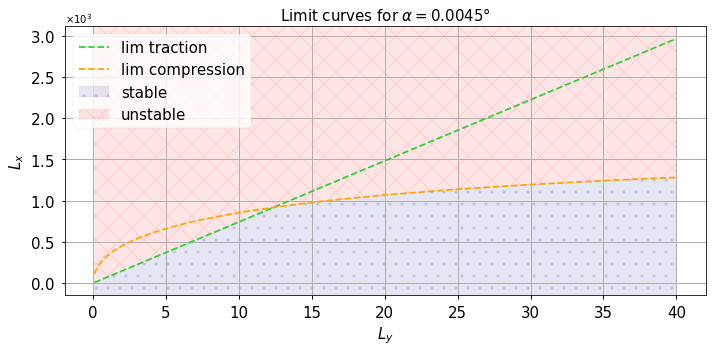

In [2]:
# parameters
Ly = np.linspace(.1, 40, 200)

# force
rho   = 2500     # [kg.m-3]
g     = 9.81     # [m.s-2]
# Ly    = 1

# geometry
alpha = .0045
fc    = 45E6
Lz    = 1.

p     = rho*Ly*Lz*g

# ------------------

def delta(a, b, c):
    
    """ Function returning delta value.
    """
    
    return b**2 - 4*a*c

def zeros_values(a, b, c):
    
    """ Function returing the zeros values of 
    an order 2 polynominomial function, given 
    parameters a, b, c.
    """
    
    Delta = delta(a, b, c)
    
    if Delta > 0:
        racineDeDelta = np.sqrt(Delta)
        retour = [(-b - racineDeDelta) / (2*a), (-b + racineDeDelta) / (2*a)]
    elif Delta < 0:
        retour = []  #liste vide
    else:
        retour = [-b / (2*a)] #liste d'un seul élément
    return retour

# --------------------------
# Physical limitations on Lx
# --------------------------
a, b, c = 3*np.sin(alpha), np.cos(alpha), -fc*Lz/p

Lx_2 = np.zeros_like(Ly)
for i in range(len(Ly)):
    x1, x2 = zeros_values(a, b, c[i])
    x = np.maximum(x1, x2)
    
    Lx_2[i] = Ly[i] * x

Lx_1 = Ly / (3*np.tan(alpha))
Lx   = np.minimum(Lx_1, Lx_2)

# ---------

fig, ax1 = plt.subplots(1, figsize=(10,5))

ax1.plot(Ly, Lx_1, '--', color='limegreen', label='lim traction')
ax1.plot(Ly, Lx_2, '--', color='orange'   , label='lim compression')

# -------------------------------
#            Axis limits
# -------------------------------

eps    = .05 # must be in [0, 1[

min_Lx = Lx[0]
max_Lx = max(np.maximum(Lx_1, Lx_2))

x_lim  = [min(Ly) - eps*max(Ly), max(Ly)*(1+eps)]
y_lim  = [min_Lx  - eps*max_Lx , max_Lx *(1+eps)]

ax1.axis((x_lim[0], x_lim[1], y_lim[0], y_lim[1]))

# -------------------------------
#           Fill between
# -------------------------------

# The lines to plot
y = Lx

# Fill with white
plt.fill_between(Ly, y_lim[0], y, color='white', alpha=1.) # t > tau ~= 400ms
plt.fill_between(Ly, y, y_lim[1], color='white', edgecolor="grey", alpha=.6) # t < 15ms

# Fill with pattern
plt.fill_between(Ly, y_lim[0], y, hatch=".", facecolor="darkblue", edgecolor="darkblue", alpha=.10, label='stable')
plt.fill_between(Ly, y, y_lim[1], hatch="x", facecolor="red"     , edgecolor="red"     , alpha=.10, label='unstable')

# ---------

ax1.set_title(r'Limit curves for $\alpha={:.2}$°'.format(alpha), size=15)
ax1.set_xlabel(r'$L_y$', size=15)
ax1.set_ylabel(r'$L_x$', size=15)

plt.xticks(size=15)
plt.yticks(size=15)

# ---- x10^ scale
    
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax1.yaxis.set_major_formatter(formatter) 

# ---------

plt.grid(True)
plt.legend(prop={'size':15})

plt.tight_layout()

# plt.savefig('Figures/Q_1_2.png')

#### Numerical application

In [3]:
eps = 1E-1
idx_0p1 = np.where((Ly < .1+eps) & (Ly > .1-eps))[0][0]
idx_1   = np.where((Ly <  1+eps) & (Ly >  1-eps))[0][0]
idx_5   = np.where((Ly <  5+eps) & (Ly >  5-eps))[0][0]
idx_10  = np.where((Ly < 10+eps) & (Ly > 10-eps))[0][0]
idx_20  = np.where((Ly < 20+eps) & (Ly > 20-eps))[0][0]

idx_35  = np.where((Ly < 35+eps) & (Ly > 35-eps))[0][0]
Lx_35   = Lx[idx_35]

# ------------

print('\n   L_y=.1m  -->  L_x={:.1f}m'.format(Lx[idx_0p1]))
print('   L_y= 1m  -->  L_x= {:.1f}m'.format(Lx[idx_1]))
print('   L_y= 5m  -->  L_x= {:.1f}m'.format(Lx[idx_5]))
print('   L_y=10m  -->  L_x={:.1f}m'.format(Lx[idx_10]))
print('   L_y=20m  -->  L_x= {:.1f}m'.format(Lx[idx_20]))


   L_y=.1m  -->  L_x=7.4m
   L_y= 1m  -->  L_x= 66.8m
   L_y= 5m  -->  L_x= 363.9m
   L_y=10m  -->  L_x=735.2m
   L_y=20m  -->  L_x= 1066.0m


We deduce a stable zone from slender beam theory where the structure can "exist" (i.e. won't collapse under it's own weight).

##### Mesh

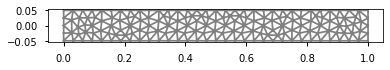

In [4]:
# data mesh
Lx, Ly = 1., .1
nx   = 20

p0   = dolfin.Point( 0, -Ly/2)
p1   = dolfin.Point(Lx, +Ly/2)

geom = mshr.Rectangle(p0, p1)
mesh = mshr.generate_mesh(geom, nx)

# mesh = dolfin.RectangleMesh(p0, p1, nx, nx) #why is it any different

# Mark boundary subdomains
left   = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
right  = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary",Lx=Lx)
bottom = dolfin.CompiledSubDomain("near(x[1], 0) && on_boundary")
top    = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary",Ly=Ly/2)

# Mark facets for Neumann BCs
boundary_indices = {'left'  : 1,
                    'right' : 2,
                    'top'   : 3,
                    'bottom': 4}

boundary_markers = dolfin.MeshFunction("size_t",
                                       mesh    ,
                                       dim  =1 ,
                                       value=0 )

left.mark  (boundary_markers, boundary_indices["left"  ])
right.mark (boundary_markers, boundary_indices["right" ])
top.mark   (boundary_markers, boundary_indices["top"   ])
bottom.mark(boundary_markers, boundary_indices["bottom"])

# Redefine element of area to include information about the markers
ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)
dolfin.plot(mesh)

# ---------

# Save mesh in an XDMF file to open in paraview.

with dolfin.XDMFFile("mesh_functions.xdmf") as f:
    f.write(boundary_markers)

##### Basis functions

In [5]:
# Finite element for displacement

V_element = dolfin.VectorElement('CG', ufl.triangle, degree=2) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")

##### Energies

In [6]:
# ---------------------------
# Energy equation - Hooke law
# ---------------------------

# Kinematics 
I  = ufl.Identity(2)    # Identity tensor
F  = ufl.variable(I + ufl.grad(u)) # u = displacement x - x_0  
C  = F.T*F                   

Ic = ufl.tr(C)
J  = ufl.det(F)

E  = 1/2*(C-I)

# ------------

# Elasticity parameters (plane-stress)
Y, nu     = 1.1E3, 0.35
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))

# line to redifine lambda if one considers plane stress
lmbda     = 2*lmbda*mu/(lmbda + 2*mu)

# --------------
# elastic energy
# --------------

psi = lmbda*ufl.tr(E)**2/2 + mu*ufl.inner(E,E) #==elastic energy with Hooke Law with eps=E

 We can have an automatic symbolic derivation of the strain energy density to define the First Piola-Kirchhoff stress 
 
 $${P}=\dfrac{\partial\Psi}{\partial F}$$
 
 To this end we use the `diff` operator of `UFL`(https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#variable-derivatives).
 
 Its use requires to define the symbol of the derivation variable as a `UFL` `variable`. 
 That is the reason why `F` in the preivous cell is defined as a `ufl.variable`.


In [7]:
P = ufl.diff(psi, F) 
n = dolfin.FacetNormal(mesh) # normal to the mesh

Hence, we can define the bulk force (`b0`) and surface traction (`g0`) and the total potential energy functional.

##### Forces

In [8]:
Gamma = 7.84
alpha = +0.0045

rho_g = Gamma * Y * Ly**2 / 12 / Lx**3
b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "+t * rho_g * sin(alpha)"),
                       t=0, alpha=alpha, rho_g=rho_g, degree=2) #degree loading (approximation sinus and cosinus) #=!0 to have non-linear terms ??

g0 = mu*dolfin.Constant((0., 0.)) # areal force (punctual in 2D)

# ----------------------
# Total potential energy
# ----------------------

potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])

As a Dirichlet Boundary condition, we block the lhs.

In [9]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

The variational problem to solve is the minimization of the potential energy with the given boundary conditions.

The problem is nonlinear and requires the use of a Newton solver. 

To this end we need to define the  *residual*, given by the first derivative of the energy, and the *Jacobian* (or *Hessian*), given by second directional derivative of the energy.

In FEniCS, thanks to the symbolic differentiation tools provided by `UFL` this can be done automatically, without effort from the user.

To this end we use the `derivative` function from `UFL` which allows us to calculate the directional derivative of a form.
We refer to the `UFL` manual for the syntax: https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#ad


##### Minimisation problem

In [10]:
# Compute first variation of the potential energy (directional derivative about u in the direction of v)
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V)) #==eps' with eps the potential energy

# Compute Jacobian of the energy
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V)) #==eps'' with eps the potential energy

All the informations about the variational problem to be solved  (residual, jacobian, bcs, and indipendent variable) can be  collected in the dolfin class `NonlinearVariationalProblem` https://fenicsproject.org/docs/dolfin/2019.1.0/cpp/db/d3d/classdolfin_1_1NonlinearVariationalProblem.html

In [11]:
# Set the variational problem
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)

We can define then a nonlinear solver class, provided by FEniCS.
This solver can implement the basic newton method or more complex nonlinear solvers (that we will not discuss in class).
A long list of parameters can be specified. 
All the nonlinear solver available in `PETSc` can be used. We suggest the reading of the PETSC user manual (Chapter 5, SNES Solver). 

In [12]:
# dolfin.PETScOptions.set("help",1)
solver = dolfin.NonlinearVariationalSolver(problem)
dolfin.info(solver.parameters, True)

<Parameter set "nonlinear_variational_solver" containing 6 parameter(s) and parameter set(s)>

  nonlinear_variational_solver  |    type   value          range  access  change
  ------------------------------------------------------------------------------
  nonlinear_solver              |  string  newton  [newton,snes]       0       0
  print_matrix                  |    bool       0        Not set       0       0
  print_rhs                     |    bool       0        Not set       0       0
  symmetric                     |    bool       0        Not set       0       0

  <Parameter set "newton_solver" containing 11 parameter(s) and parameter set(s)>
  
    newton_solver            |    type     value    range  access  change
    ---------------------------------------------------------------------
    absolute_tolerance       |  double  0.000000  Not set       0       0
    convergence_criterion    |  string  residual  Not set       0       0
    error_on_nonconvergence  |    boo

## Part 2 - Bifurcation diagram

t set       0       0
      monitor_convergence      |    bool  <unset>  Not set       0       0
      nonzero_initial_guess    |    bool  <unset>  Not set       0       0
      relative_tolerance       |  double  <unset>  Not set       0       0
      report                   |    bool  <unset>  Not set       0       0
  
    <Parameter set "lu_solver" containing 3 parameter(s) and parameter set(s)>
    
      lu_solver  |  type  value    range  access  change
      --------------------------------------------------
      report     |  bool      1  Not set       0       0
      symmetric  |  bool      0  Not set       0       0
      verbose    |  bool      0  Not set       0       0

  <Parameter set "snes_solver" containing 14 parameter(s) and parameter set(s)>
  
    snes_solver                   |    type     value                              range  access  change
    ----------------------------------------------------------------------------------------------------
    absolute

  Newton iteration 0: r (abs) = 1.319e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 9.612e-02 (tol = 1.000e-10) r (rel) = 7.285e+01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.227e-04 (tol = 1.000e-10) r (rel) = 1.688e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.416e-04 (tol = 1.000e-10) r (rel) = 1.831e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.944e-09 (tol = 1.000e-10) r (rel) = 1.474e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 6.594e-13 (tol = 1.000e-10) r (rel) = 4.998e-10 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.319e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.349e-01 (tol = 1.000e-10) r (rel) = 1.022e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.769e-04 (tol = 1.000e-10) r (rel) = 2.098e-01 (tol = 1.000e-09)
  Newt

  Newton iteration 1: r (abs) = 7.674e-01 (tol = 1.000e-10) r (rel) = 5.816e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.261e-03 (tol = 1.000e-10) r (rel) = 2.471e+00 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.471e-04 (tol = 1.000e-10) r (rel) = 4.147e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 4.668e-07 (tol = 1.000e-10) r (rel) = 3.538e-04 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.101e-11 (tol = 1.000e-10) r (rel) = 8.345e-09 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.319e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.696e-01 (tol = 1.000e-10) r (rel) = 5.075e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.483e-03 (tol = 1.000e-10) r (rel) = 1.882e+00 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 4.502e-04 (tol = 1.000e-10) r (rel) = 3.412e-01 (tol = 1.000e-09)
  Newt

  Newton iteration 2: r (abs) = 2.024e-04 (tol = 1.000e-10) r (rel) = 1.534e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.370e-05 (tol = 1.000e-10) r (rel) = 1.038e-02 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.351e-11 (tol = 1.000e-10) r (rel) = 1.024e-08 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.319e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.627e-01 (tol = 1.000e-10) r (rel) = 1.233e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.738e-04 (tol = 1.000e-10) r (rel) = 1.317e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 9.915e-06 (tol = 1.000e-10) r (rel) = 7.515e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 8.772e-12 (tol = 1.000e-10) r (rel) = 6.648e-09 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational p

  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.319e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.805e-02 (tol = 1.000e-10) r (rel) = 1.368e+01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.483e-05 (tol = 1.000e-10) r (rel) = 4.155e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.367e-06 (tol = 1.000e-10) r (rel) = 1.036e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 4.262e-13 (tol = 1.000e-10) r (rel) = 3.230e-10 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.319e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.297e-02 (tol = 1.000e-10) r (rel) = 1.741e+01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.199e-05 (tol = 1.000e-10) r (rel) = 5.456e-02 (tol = 1.0

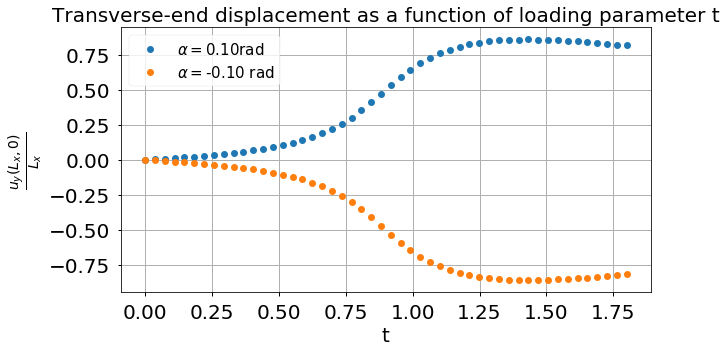

In [13]:
# iterate over these loads
loads = np.linspace(0, 1.8, 50)
displ = np.zeros_like(loads)

u.interpolate(dolfin.Constant((0., 0.))) # initial guess

file_u = dolfin.XDMFFile("output/u.xdmf")
file_u.parameters.update({"flush_output": True,
                          "functions_share_mesh": True,
                          "rewrite_function_mesh":False})

# ---------------------------------------------------------------------

alpha = 0.1
b0.alpha = +alpha

# loop to get value of vertical displacement as a function of loading
b0.t = 0
for (i, t) in enumerate(loads):
    b0.t = t # volumic force (downwards)
    solver.solve() # solve
    
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly # mean at rhs for v again

# ---------------------------------------------------------------------

plt.figure(2, figsize=(10,5))

plt.plot(loads, displ / Lx, "o", label=r'$\alpha=${:.2f}rad'.format(b0.alpha))

# -------------------------------------------------------------------- #

b0.alpha = -alpha

# loop to get value of vertical displacement as a function of loading
b0.t = 0
for (i, t) in enumerate(loads):
    b0.t = t # volumic force (downwards)
    solver.solve() # solve
    
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly # mean at rhs for v again

# -------------------------------------------------------------------- #

plt.plot(loads, displ / Lx, "o", label=r'$\alpha=${:.2f} rad'.format(b0.alpha))

plt.title('Transverse-end displacement as a function of loading parameter t', size=20)
plt.xlabel('t', size=20)
plt.ylabel(r'$\frac{u_y(L_x, 0)}{L_x}$', size=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.grid(True)
plt.legend(prop={'size':15})

plt.tight_layout()

# plt.savefig('Figures/Stability_Q_2_1.png')

Buckling is facilitated ($\equiv$ forced) by setting an angle alpha.

We then observe that bigger the load, the more the beam's end deflects until it's almost constant. It's most likely the buckling tends towards its equilibrium for given alpha. Then, if one furthermore increase loading, then the beam may diverge, namely break.

## Part 3 - Numerical non-linear limit

In this part we consider a real application where the beam is made of concrete (which shares the physical properties of being brittle in traction).

##### Data

In [14]:
# Material
rho = 2500 #[kg.m-3]
nu  = 0.35 #[-]
E   = 37E9 #[Pa]
fc  = 45E6 #[Pa]

# Forces
g     = 9.80    #[m.s-2]
alpha = 0.0045 #[-]

# Miscellaneous
K     = (E / (12 * rho * g))**(1/3)

$\Gamma = 12\dfrac{\rho.g.L_x^3}{E.L_y^2}$ $~~~~$ $\iff$ $~~~~$ $L_x = \left(\frac{E}{12.\rho.g} \right)^{1/3} \times \left(\Gamma L_y^2 \right)^{1/3} = K . \left(\Gamma L_y^2 \right)^{1/3}$

In [15]:
def function_Lx(Gamma, Ly, K):
    
    """ Function returing Lx given
    Gamma, Ly and constant K (see 
    associated eq°).
    """
    
    return K * (Gamma*Ly**2)**(1/3)

The factor $\Gamma$ can be used to build limitations for Lx, Ly. Indeed, $\Gamma=7.8$ is the limit one can't get past. 

It then provides a limit accounting for non-linear terms (the one neglected in expression of $\sigma_{xx}$, from which Lx_i curves derive).

##### 3.1

In [16]:
# If Gamma = 7.8 & Ly = 10m :

Gamma     = 7.8 #[-]
Ly        = 10  #[m]
L_x_78_10 = function_Lx(Gamma, Ly, K)

print('L_x ~= {:.1f}m'.format(L_x_78_10))

L_x ~= 461.3m


##### 3.2

We recall that for $L_y=10$m, the length $L_x$ is limited by the fact there is **traction** at lhs. We then got $L_{{x}_{max}} \approx 745.7$m. 

We then see the non-linear effects limit furthermore $L_x$.

##### 3.3

In [17]:
# If Gamma = 7.8 & Ly = 20m :

Gamma     = 7.8 #[-]
Ly        = 20  #[m]
L_x_78_20 = function_Lx(Gamma, Ly, K)

print('L_x ~= {:.1f}m'.format(L_x_78_20))

L_x ~= 732.3m


##### 3.4

We recall that for $L_y=20$m, the length $L_x$ is limited by the limit in **compression** due to loading limit. We then got $L_{{x}_{max}} \approx 1067.3$m. 

We have a new limitation for $L_x$.

As a result, let's do the same observation for another value of $L_y$ and plot a new graph ($L_x$, $L_y$).

##### 3.5

In [18]:
# If Gamma = 7.8 & Ly = 35m :

Gamma     = 7.8 #[-]
Ly        = 35  #[m]
L_x_78_35 = function_Lx(Gamma, Ly, K)

# ------------

print('L_x~={:.1f}m while we had {:.1f}m for linear theory.'.format(L_x_78_35, Lx_35))

L_x~=1063.4m while we had 1240.8m for linear theory.


##### 3.6

We can see we now have only one curve limiting the dependance (Lx, Ly) and that this curve is more restrictive than was the previous one.

The theory with $\Gamma$ accounts for limit buckling when $\alpha \rightarrow 0$ rad such that :
* one of our curve won't limit anymore (the one associated with possible traction)
* the other one will be the one limiting the system (limit compression)
* both $\gamma$ and non-liner methods should tend to the same limit (?)

About this last point, maybe it's not the case or we have simplification that make this affiramtion true within an error.

### a. Adimensionalisation

We must go though adim to solve the problem. We non-dimensionalize a pressure and a length unit.

In [19]:
# self consistent cell to solve the flexion problem in linearized case.
# the linearisation is used with Newton method and works under a good 
# equilibrium between energy and time steps (e.g. if we consider b0 too 
# big we have too big jump of energy when trying to minimize)

# -----------
# Libraries
# -----------

import numpy as np
import matplotlib.pyplot as plt

import dolfin
import ufl
import mshr

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

# -----------
#     Code
# -----------

I2 = dolfin.Identity(2)

def stress_strain(eps, lambda_, mu):
    
    """ Function returning stress
    tensor provided strain tensor.
    """
    
    return lambda_ * dolfin.tr(eps) * I2 + 2. * mu * eps

def tensors(dim, u):

    """ Function returning some useful tensor 
    for non-linear resolution of energy mini-
    misation problem with Hooke law.
    """

    I  = ufl.Identity(dim)
    F  = ufl.variable(I + ufl.grad(u))  
    C  = F.T*F                   

    # ---------

    Ic = ufl.tr(C)
    J  = ufl.det(F)
    E  = 1/2*(C-I)
        
    return I, F, C, Ic, J, E

# -----------------------------

b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "+t * rho_g * sin(alpha)"),
                       t=0, alpha=0, rho_g=0, degree=2) #degree loading (approximation sinus and cosinus) #=!0 to have non-linear terms ??

def solve_nonlinear_elasticity__Lx_adim(load_min=0., load_max=2., nload=20, nsteps=50, nu=0.35, Young=37.E9, nx=20, L_x=1., L_y=.1):
    
    """ Function solving the non-linear flexion of a 2D beam. 
    Entry parameters are initialize to provide a working example.
    """
    
    # ------
    #  Mesh
    # ------

    dim    = 2
    degree = 2

    # -----

    alpha = 0.0045
    
    for (i, Lx) in enumerate(L_x):    
        
        # adim
        x_star        = L_x[-1]
        sigma_star    = 1.E10
        
#         x_real        = Lx
#         x_bar         = x_real/x_star
        
        Lx = Lx  #x_bar
        Ly = L_y
        
#         print('Lx={:.2f}'.format(Lx))
#         print('Ly={:.2f}'.format(Ly))
        
        # ------
        # Forces
        # ------

        rho_real = 2500
        g_real   = 9.80

        rho_g = rho_real*g_real / sigma_star
        
        # -----

        fc_real       = 45E6
        fc = fc_real / sigma_star

        # Elasticity parameters (plane-stress)
        Y_real, nu = Young, nu
        Y  = Y_real / sigma_star
        
#         print('sigma_star ~= {:.2f}'.format(sigma_star))
        
        mu, lmbda  = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
        
        # line to redifine lambda if one considers plane stress
        lmbda      = 2*lmbda*mu/(lmbda + 2*mu)
        
        # -----------------------------
    
        # ------
        #  mesh
        # ------
        
        p0     = dolfin.Point( 0, -Ly/2)
        p1     = dolfin.Point(Lx, +Ly/2)

        geom   = mshr.Rectangle(p0, p1)
        mesh   = mshr.generate_mesh(geom, nx)
#         ny     = int(nx*Lx/Ly) # have good proportionality between Nx and Ny
#         mesh   = dolfin.RectangleMesh(p0, p1, nx, ny)
        
        # -----------
        # boundaries
        # -----------

        # Mark boundary subdomains
        left   = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
        right  = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx = +Lx  )
        bottom = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary", Ly = -Ly/2)
        top    = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary", Ly = +Ly/2)

        # Mark facets for Neumann BCs
        boundary_indices = {'left'  : 1,
                            'right' : 2,
                            'top'   : 3,
                            'bottom': 4}

        boundary_markers = dolfin.MeshFunction("size_t",
                                               mesh    ,
                                               dim  =1 ,
                                               value=0 )

        left.mark  (boundary_markers, boundary_indices["left"  ])
        right.mark (boundary_markers, boundary_indices["right" ])
        top.mark   (boundary_markers, boundary_indices["top"   ])
        bottom.mark(boundary_markers, boundary_indices["bottom"])

        # Redefine element of area to include information about the markers
        ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
        dx = dolfin.dx(domain=mesh)

        # --------------
        # Basis function
        # --------------

        # Finite element for displacement

        V_element = dolfin.VectorElement('CG', ufl.triangle, degree=2) 
        V = dolfin.FunctionSpace(mesh, V_element)
        u = dolfin.Function(V, name="u")

        # ---------
        #  Tensors
        # ---------

        I, F, C, Ic, J, E = tensors(dim, u)

        # ----------
        #   Forces
        # ----------

#         rho_g = rho*g #Gamma * Y * Ly**2 / 12 / Lx**3
        b0.alpha, b0.rho_g = alpha, rho_g

        g0 = mu*dolfin.Constant((0., 0.)) # areal force (punctual in 2D)

        # ----

        bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

        # -----------------------------------------
        #                 Hooke model 
        # -----------------------------------------

        psi = lmbda*ufl.tr(E)**2/2 + mu*ufl.inner(E,E)
        potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])

        P = ufl.diff(psi, F) 
        n = dolfin.FacetNormal(mesh) # normal to the mesh

        # ------------------
        #  Weak formulation
        # ------------------

        residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V)) #==eps'(u)(v) with eps the potential energy
        jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V)) #==eps''(u)(v)(w) with eps the potential energy

        # Solving
        problem  = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
        solver   = dolfin.NonlinearVariationalSolver(problem)

        # minimize energy / save values
        loads    = np.linspace(load_min, load_max, nload)
        displ    = np.zeros_like(loads)

        # u
        u.interpolate(dolfin.Constant((0.,0.))) # initial guess

        file_u   = dolfin.XDMFFile("output/u.xdmf")
        file_u.parameters.update({"flush_output": True,
                                  "functions_share_mesh": True,
                                  "rewrite_function_mesh": False})

        # sigma / eps
        E_project = dolfin.FiniteElement('CG', cell=dolfin.triangle, degree=1)
        V_project = dolfin.FunctionSpace(mesh, E_project)

        # -------------------------
        # get positions y= +/- Ly/2
        # -------------------------
        
        idx_traction = np.where((V_project.tabulate_dof_coordinates()[:,0]==0) & (V_project.tabulate_dof_coordinates()[:,1]==-Ly/2))[0][0]
        idx_compression = np.where((V_project.tabulate_dof_coordinates()[:,0]==0) & (V_project.tabulate_dof_coordinates()[:,1]==+Ly/2))[0][0]
#         print(idx_traction, idx_compression)
        
        # -----
    
        b0.t = 0
        eps  = 1E-10

        for (j, t) in enumerate(loads):
            b0.t = t         # gravity force along ex_1        
            solver.solve()

            displ[j] = dolfin.assemble(u[1]*ds(2))/Ly # mean at rhs for v again

        # strain & stress
        I, F, C, Ic, J, E = tensors(dim, u)

        E = E # non-linear deformation tensor
        psi = (lmbda*ufl.tr(E)**2/2 + mu*ufl.inner(E,E))

        sig    = ufl.diff(psi, F)
        sig_xx = dolfin.project(P[0,0], V_project)
        sig_xx_local = sig_xx.vector().get_local()

        # -----
        
        sig_xx_traction = sig_xx_local[idx_traction]
        sig_xx_compression = sig_xx_local[idx_compression]
            
        # -----
        
        if np.abs(sig_xx_compression) > fc +eps: # a bit higher than limit fc
            print('\nLimit compression : {:.2f} Pa'.format(sig_xx_compression * sigma_star))
            print('Lx={:.2f}m'.format(Lx))
#             return loads, displ, u, Lx

        if sig_xx_traction > eps:
            print('\nLimit traction : {:.2f} Pa'.format(sig_xx_traction * sigma_star))
            print('Lx={:.2f}m'.format(Lx))
#             return loads, displ, u, Lx        
            
        with file_u as file:
            file.write(u, t)
        
    return loads, displ, u, Lx

Cell providing the limit point traction/compression

In [20]:
L_y = np.linspace(22., 50., 1) #Lx/Ly such that we consider Lx=1 and Ly=ratio*1. #ex we chose .1 so far

for (i, Ly) in enumerate(L_y):
    
    L_x = np.linspace(500, 600., 15 +1)
    
    print('\n # ----------- #')
    print('   For Ly={:.1f}'.format(Ly))
    loads, displ, usol, Lx = solve_nonlinear_elasticity__Lx_adim(load_min=0., load_max=1.8, nload=20, nsteps=50, nu=0.35, Young=37.E9, nx=20, L_x=L_x, L_y=Ly)


 # ----------- #
   For Ly=22.0
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.779e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.178e-06 (tol = 1.000e-10) r (rel) = 2.348e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.858e-09 (tol = 1.000e-10) r (rel) = 1.606e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.234e-14 (tol = 1.000e-10) r (rel) = 2.942e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.779e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.630e-06 (tol = 1.000e-10) r (rel) = 2.603e-02 (tol = 1.000e-09)
  Newton iteration 2: r

  Newton iteration 2: r (abs) = 8.014e-08 (tol = 1.000e-10) r (rel) = 4.505e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.247e-13 (tol = 1.000e-10) r (rel) = 7.009e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.779e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.648e-05 (tol = 1.000e-10) r (rel) = 2.613e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.047e-07 (tol = 1.000e-10) r (rel) = 5.885e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.310e-13 (tol = 1.000e-10) r (rel) = 1.298e-09 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear vari

  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.803e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.016e-05 (tol = 1.000e-10) r (rel) = 2.228e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 8.711e-08 (tol = 1.000e-10) r (rel) = 4.832e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.417e-13 (tol = 1.000e-10) r (rel) = 7.858e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.803e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.818e-05 (tol = 1.000e-10) r (rel) = 2.673e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.146e-07 (tol = 1.000e-10) r (rel) = 6.356e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.769e-13 (tol = 1.000e-10) r (rel) = 1.536e-09 (tol = 1.0

  Newton iteration 1: r (abs) = 3.429e-05 (tol = 1.000e-10) r (rel) = 1.877e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.119e-08 (tol = 1.000e-10) r (rel) = 3.898e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 9.004e-14 (tol = 1.000e-10) r (rel) = 4.929e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.827e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.098e-05 (tol = 1.000e-10) r (rel) = 2.243e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.307e-08 (tol = 1.000e-10) r (rel) = 5.095e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.555e-13 (tol = 1.000e-10) r (rel) = 8.512e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.827e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.0

  Newton iteration 1: r (abs) = 1.516e-05 (tol = 1.000e-10) r (rel) = 8.089e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.250e-08 (tol = 1.000e-10) r (rel) = 1.200e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.336e-14 (tol = 1.000e-10) r (rel) = 2.847e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.874e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.763e-05 (tol = 1.000e-10) r (rel) = 9.408e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.819e-08 (tol = 1.000e-10) r (rel) = 1.505e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.584e-14 (tol = 1.000e-10) r (rel) = 2.980e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.874e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.0

  Newton iteration 3: r (abs) = 5.342e-14 (tol = 1.000e-10) r (rel) = 2.746e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.945e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.226e-05 (tol = 1.000e-10) r (rel) = 1.144e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.432e-08 (tol = 1.000e-10) r (rel) = 2.278e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.324e-14 (tol = 1.000e-10) r (rel) = 2.737e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.945e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.650e-05 (tol = 1.000e-10) r (rel) = 1.363e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.756e-08 (tol = 1.000e-10) r (rel) = 2.959e-04 (tol = 1.0

  Newton iteration 1: r (abs) = 2.125e-05 (tol = 1.000e-10) r (rel) = 1.079e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.277e-08 (tol = 1.000e-10) r (rel) = 2.172e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.829e-14 (tol = 1.000e-10) r (rel) = 2.960e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.969e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.532e-05 (tol = 1.000e-10) r (rel) = 1.286e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.561e-08 (tol = 1.000e-10) r (rel) = 2.824e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 6.369e-14 (tol = 1.000e-10) r (rel) = 3.235e-10 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.969e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.0

  Newton iteration 1: r (abs) = 8.352e-05 (tol = 1.000e-10) r (rel) = 4.192e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.459e-07 (tol = 1.000e-10) r (rel) = 1.736e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.866e-12 (tol = 1.000e-10) r (rel) = 1.438e-08 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.993e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.072e-04 (tol = 1.000e-10) r (rel) = 5.382e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.043e-07 (tol = 1.000e-10) r (rel) = 2.531e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.805e-12 (tol = 1.000e-10) r (rel) = 3.917e-08 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.993e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.0

  Newton iteration 0: r (abs) = 2.016e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.205e-05 (tol = 1.000e-10) r (rel) = 3.078e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.284e-07 (tol = 1.000e-10) r (rel) = 1.133e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 8.957e-13 (tol = 1.000e-10) r (rel) = 4.442e-09 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.016e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.856e-05 (tol = 1.000e-10) r (rel) = 3.896e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.259e-07 (tol = 1.000e-10) r (rel) = 1.616e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.286e-12 (tol = 1.000e-10) r (rel) = 1.134e-08 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational p

  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.040e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.224e-04 (tol = 1.000e-10) r (rel) = 6.001e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 6.576e-07 (tol = 1.000e-10) r (rel) = 3.224e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.382e-11 (tol = 1.000e-10) r (rel) = 6.773e-08 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.040e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.626e-04 (tol = 1.000e-10) r (rel) = 7.972e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.010e-06 (tol = 1.000e-10) r (rel) = 4.950e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 4.320e-11 (tol = 1.000e-10) r (rel) = 2.117e-07 (tol = 1.0

04 (tol = 1.000e-10) r (rel) = 5.453e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.983e-07 (tol = 1.000e-10) r (rel) = 2.899e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.006e-11 (tol = 1.000e-10) r (rel) = 4.877e-08 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.064e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.493e-04 (tol = 1.000e-10) r (rel) = 7.233e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.165e-07 (tol = 1.000e-10) r (rel) = 4.441e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.125e-11 (tol = 1.000e-10) r (rel) = 1.514e-07 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.064e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) =

  Newton iteration 2: r (abs) = 1.287e-06 (tol = 1.000e-10) r (rel) = 6.167e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.230e-11 (tol = 1.000e-10) r (rel) = 3.463e-07 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.087e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.531e-04 (tol = 1.000e-10) r (rel) = 1.213e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.099e-06 (tol = 1.000e-10) r (rel) = 1.005e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.661e-10 (tol = 1.000e-10) r (rel) = 1.275e-06 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 6.723e-14 (tol = 1.000e-10) r (rel) = 3.221e-10 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.087e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.0

  Newton iteration 2: r (abs) = 7.730e-05 (tol = 1.000e-10) r (rel) = 3.661e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.727e-06 (tol = 1.000e-10) r (rel) = 3.660e-02 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.772e-10 (tol = 1.000e-10) r (rel) = 1.787e-06 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.048e-13 (tol = 1.000e-10) r (rel) = 4.966e-10 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.135e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.486e-05 (tol = 1.000e-10) r (rel) = 6.961e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.152e-08 (tol = 1.000e-10) r (rel) = 1.476e-04 (tol = 1.000e-0

We deduce following values

In [21]:
non_lin_lim_traction = np.zeros((2, 40))
non_lin_lim_traction[0,:]    = np.array([_+1 for _ in range(np.size(non_lin_lim_traction, 1))])
non_lin_lim_traction[1,:]    = [40., 54.4, 94.3, 130., 162., 192., 220., 248., 274., 298., 322., 346., 372., 396., 418., 440., 460., 480., 500., 520., 542., 558., 578., 600., 614., 632., 650., 666., 684., 719., 734., 752., 768., 785., 800., 820., 830., 844., 860., 875.]

non_lin_lim_compression = np.zeros((2, 40))
non_lin_lim_compression[0,:] = np.array([_+1 for _ in range(np.size(non_lin_lim_traction, 1))])
non_lin_lim_compression[1,:] = [70., 82.9, 130., 165., 198., 228., 256., 282., 308., 330., 352., 374., 394., 414., 432., 448., 466., 482., 498., 512., 526., 540., 554., 566., 578., 590., 600., 612., 624., 634., 644., 654., 662., 670., 680., 688., 695., 708., 714., 708.]

r (rel) = 1.987e-09 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.135e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.379e-05 (tol = 1.000e-10) r (rel) = 2.988e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.795e-07 (tol = 1.000e-10) r (rel) = 1.309e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.099e-12 (tol = 1.000e-10) r (rel) = 5.149e-09 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.135e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 8.246e-05 (tol = 1.000e-10) r (rel) = 3.862e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.115e-07 (tol = 1.000e-10) r (rel) = 1.927e-03 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.077e-12 (tol = 1.0

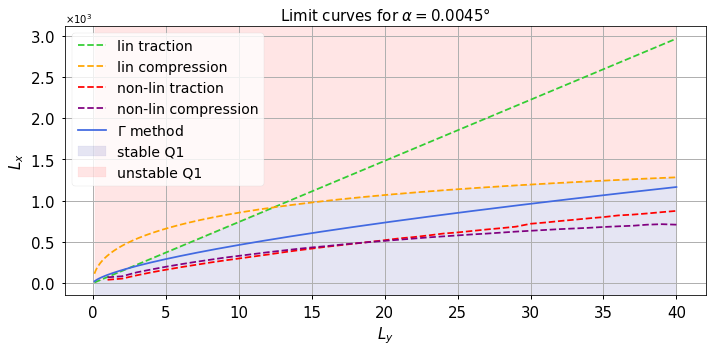

In [22]:
# parameters
Ly = np.linspace(.1, 40, 500)

# Material
rho = 2500 #[kg.m-3]
nu  = 0.35 #[-]
E   = 37E9 #[Pa]
fc  = 45E6 #[Pa]

# Geometry
Lz    = 1.

# Forces
g     = 9.80    #[m.s-2]
alpha = 0.0045 #[-]

p     = rho*Ly*Lz*g

# Miscellaneous
Gamma = 7.84
K     = (E / (12 * rho * g))**(1/3)

# ------------------

def delta(a, b, c):
    
    """ Function returning delta value.
    """
    
    return b**2 - 4*a*c


def zeros_values(a, b, c):
    
    """ Function returing the zeros values of 
    an order 2 polynominomial function, given 
    parameters a, b, c.
    """
    
    Delta = delta(a, b, c)
    
    if Delta > 0:
        racineDeDelta = np.sqrt(Delta)
        retour = [(-b - racineDeDelta) / (2*a), (-b + racineDeDelta) / (2*a)]
    elif Delta < 0:
        retour = []  #liste vide
    else:
        retour = [-b / (2*a)] #liste d'un seul élément
    return retour

# --------------------------
# Physical limitations on Lx
# --------------------------
a, b, c = 3*np.sin(alpha), np.cos(alpha), -fc*Lz/p

Lx_2 = np.zeros_like(Ly)
for i in range(len(Ly)):
    x1, x2 = zeros_values(a, b, c[i])
    x = np.maximum(x1, x2)
    
    Lx_2[i] = Ly[i] * x

Lx_1 = Ly / (3*np.tan(alpha))
Lx   = np.minimum(Lx_1, Lx_2)

# ---------

fig, ax1 = plt.subplots(1, figsize=(10,5))

ax1.plot(Ly, Lx_1, '--', color='limegreen', label='lin traction')
ax1.plot(Ly, Lx_2, '--', color='orange'   , label='lin compression')

ax1.plot(non_lin_lim_traction[0,:], non_lin_lim_traction[1,:], '--', color='red', label='non-lin traction')
ax1.plot(non_lin_lim_compression[0,:], non_lin_lim_compression[1,:], '--', color='purple', label='non-lin compression')

ax1.plot(Ly, function_Lx(Gamma, Ly, K), '-', color='royalblue', label=r'$\Gamma$ method')

# -------------------------------
#            Axis limits
# -------------------------------

eps    = .05 # must be in [0, 1[

min_Lx = Lx[0]
max_Lx = max(np.maximum(Lx_1, Lx_2))

x_lim  = [min(Ly) - eps*max(Ly), max(Ly)*(1+eps)]
y_lim  = [min_Lx  - eps*max_Lx , max_Lx *(1+eps)]

ax1.axis((x_lim[0], x_lim[1], y_lim[0], y_lim[1]))

# -------------------------------
#           Fill between
# -------------------------------

# The lines to plot
y = Lx

# Fill with white
plt.fill_between(Ly, y_lim[0], y, color='white', alpha=1.) # t > tau ~= 400ms
plt.fill_between(Ly, y, y_lim[1], color='white', edgecolor="grey", alpha=.6) # t < 15ms

# Fill with pattern
plt.fill_between(Ly, y_lim[0], y, facecolor="darkblue", edgecolor="darkblue", alpha=.10, label='stable Q1')
plt.fill_between(Ly, y, y_lim[1], facecolor="red"     , edgecolor="red"     , alpha=.10, label='unstable Q1')

# ---------

ax1.set_title(r'Limit curves for $\alpha={:.2}$°'.format(alpha), size=15)
ax1.set_xlabel(r'$L_y$', size=15)
ax1.set_ylabel(r'$L_x$', size=15)

plt.xticks(size=15)
plt.yticks(size=15)

# ---- x10^ scale
    
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax1.yaxis.set_major_formatter(formatter) 

# ---------

plt.grid(True)
plt.legend(prop={'size':14})

plt.tight_layout()

# plt.savefig('Figures/Q_3_6.png')

## Part 4 - 2nd bifurcation

Let's recall the functions to make sure the code works

#### Mesh

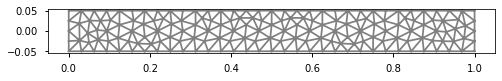

In [23]:
# data mesh
Lx, Ly = 1., .1
nx   = 20

p0   = dolfin.Point( 0, -Ly/2)
p1   = dolfin.Point(Lx, +Ly/2)

geom = mshr.Rectangle(p0, p1)
mesh = mshr.generate_mesh(geom, nx)

# mesh = dolfin.RectangleMesh(p0, p1, nx, nx) #why is it any different

# Mark boundary subdomains
left   = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
right  = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary",Lx=Lx)
bottom = dolfin.CompiledSubDomain("near(x[1], 0) && on_boundary")
top    = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary",Ly=Ly/2)

# Mark facets for Neumann BCs
boundary_indices = {'left'  : 1,
                    'right' : 2,
                    'top'   : 3,
                    'bottom': 4}

boundary_markers = dolfin.MeshFunction("size_t",
                                       mesh    ,
                                       dim  =1 ,
                                       value=0 )

left.mark  (boundary_markers, boundary_indices["left"  ])
right.mark (boundary_markers, boundary_indices["right" ])
top.mark   (boundary_markers, boundary_indices["top"   ])
bottom.mark(boundary_markers, boundary_indices["bottom"])

# Redefine element of area to include information about the markers
ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)
dolfin.plot(mesh)

# ---------

# Save mesh in an XDMF file to open in paraview.

with dolfin.XDMFFile("mesh_functions.xdmf") as f:
    f.write(boundary_markers)

In [24]:
# Finite element for displacement

V_element = dolfin.VectorElement('CG', ufl.triangle, degree=2) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")

In [25]:
# ---------------------------
# Energy equation - Hooke law
# ---------------------------

# Kinematics 
I  = ufl.Identity(2)    # Identity tensor
F  = ufl.variable(I + ufl.grad(u)) # u = displacement x - x_0  
C  = F.T*F                   

Ic = ufl.tr(C)
J  = ufl.det(F)

E  = 1/2*(C-I)

# ------------

# Elasticity parameters (plane-stress)
Y, nu     = 1.1E3, 0.35
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))

# line to redifine lambda if one considers plane stress
lmbda     = 2*lmbda*mu/(lmbda + 2*mu)

# --------------
# elastic energy
# --------------

psi = lmbda*ufl.tr(E)**2/2 + mu*ufl.inner(E,E) #==elastic energy with Hooke Law with eps=E

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.685e-07 (tol = 1.000e-10) r (rel) = 4.570e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.191e-14 (tol = 1.000e-10) r (rel) = 3.958e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.684e-07 (tol = 1.000e-10) r (rel) = 4.569e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.190e-14 (tol = 1.000e-10) r (rel) = 3.957e-11 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear so

  Newton solver finished in 2 iterations and 2 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.673e-07 (tol = 1.000e-10) r (rel) = 4.556e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.834e-13 (tol = 1.000e-10) r (rel) = 4.754e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.673e-07 (tol = 1.000e-10) r (rel) = 4.555e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.920e-13 (tol = 1.000e-10) r (rel) = 6.102e-10 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e

  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.207e-07 (tol = 1.000e-10) r (rel) = 6.458e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.434e-08 (tol = 1.000e-10) r (rel) = 5.498e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.156e-14 (tol = 1.000e-10) r (rel) = 3.914e-11 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.063e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.268e-06 (tol = 1.000e-10) r (rel) = 1.573e-03 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.397e-07 (tol = 1.000e-10) r (rel) = 4.213e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.342e-14 (tol = 1.000e-10) r (rel) = 4.144e-11 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational p

  Newton iteration 0: r (abs) = 1.393e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.196e-05 (tol = 1.000e-10) r (rel) = 3.731e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.038e-07 (tol = 1.000e-10) r (rel) = 1.463e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.605e-14 (tol = 1.000e-10) r (rel) = 4.024e-11 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.393e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.012e-05 (tol = 1.000e-10) r (rel) = 2.881e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.408e-07 (tol = 1.000e-10) r (rel) = 1.011e-04 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.591e-14 (tol = 1.000e-10) r (rel) = 4.014e-11 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational p

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.393e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.203e-06 (tol = 1.000e-10) r (rel) = 8.635e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.882e-10 (tol = 1.000e-10) r (rel) = 3.505e-07 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.379e-14 (tol = 1.000e-10) r (rel) = 3.862e-11 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.393e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.183e-06 (tol = 1.000e-10) r (rel) = 8.494e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.379e-10 (tol = 1.000e-10) r (rel) = 3.144e-07 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 5.721e-14 (tol = 1.000e-10) r (rel) = 4.108e-11 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iter

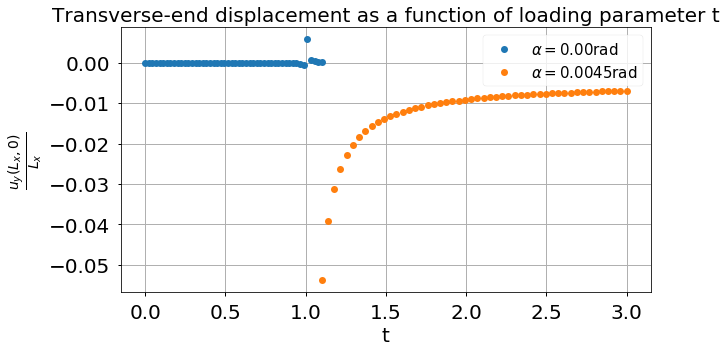

In [34]:
# iterate over these loads
t0 = 0; t1 = 1.1; t2 = 3.

loads_1 = np.linspace(t0, t1, 50)
loads_2 = np.linspace(t1, t2, 50)

displ   = np.zeros((len(loads_1)+len(loads_2)))

u.interpolate(dolfin.Constant((0., 0.))) # initial guess

file_u  = dolfin.XDMFFile("output/u.xdmf")
file_u.parameters.update({"flush_output": True,
                          "functions_share_mesh": True,
                          "rewrite_function_mesh":False})

# ---------------------------------------------------------------------
# Through P_1

alpha    = 0.0
b0.alpha = alpha

# loop to get value of vertical displacement as a function of loading
b0.t = 0
for (i, t) in enumerate(loads_1):
    b0.t = t # volumic force (downwards)
    solver.solve() # solve
    
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly # mean at rhs for v again

# ---------------------------------------------------------------------
# To P_2

alpha    = 0.0045
b0.alpha = alpha

# loop to get value of vertical displacement as a function of loading
for (i, t) in enumerate(loads_2):
    b0.t = t # volumic force (downwards)
    solver.solve() # solve
    
    displ[i+len(loads_1)] = dolfin.assemble(u[1]*ds(2))/Ly # mean at rhs for v again

# ------

plt.figure(2, figsize=(10,5))

plt.plot(loads_1, displ[:len(loads_1)] / Lx, "o", label=r'$\alpha=${:.2f}rad'.format(b0.alpha))
plt.plot(loads_2, displ[len(loads_1):] / Lx, "o", label=r'$\alpha=${:.4f}rad'.format(b0.alpha))

plt.title('Transverse-end displacement as a function of loading parameter t', size=20)
plt.xlabel('t', size=20)
plt.ylabel(r'$\frac{u_y(L_x, 0)}{L_x}$', size=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.grid(True)
plt.legend(prop={'size':15})

plt.tight_layout()

# plt.savefig('Figures/Stability_Q_4_1.png')

In [27]:
Gamma = 7.84
alpha = +0.0045

rho_g = Gamma * Y * Ly**2 / 12 / Lx**3
b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "+t * rho_g * sin(alpha)"),
                       t=0, alpha=alpha, rho_g=rho_g, degree=2) #degree loading (approximation sinus and cosinus) #=!0 to have non-linear terms ??

g0 = mu*dolfin.Constant((0., 0.)) # areal force (punctual in 2D)

# ----------------------
# Total potential energy
# ----------------------

potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])

In [28]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

In [29]:
# Compute first variation of the potential energy (directional derivative about u in the direction of v)
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V)) #==eps' with eps the potential energy

# Compute Jacobian of the energy
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V)) #==eps'' with eps the potential energy

# Set the variational problem
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)

In [30]:
# dolfin.PETScOptions.set("help",1)
solver = dolfin.NonlinearVariationalSolver(problem)
dolfin.info(solver.parameters, True)

#solver.parameters.update({"nonlinear_solver":"snes"})
#dolfin.PETScOptions.set("snes_type","newtonls")

<Parameter set "nonlinear_variational_solver" containing 6 parameter(s) and parameter set(s)>

  nonlinear_variational_solver  |    type   value          range  access  change
  ------------------------------------------------------------------------------
  nonlinear_solver              |  string  newton  [newton,snes]       0       0
  print_matrix                  |    bool       0        Not set       0       0
  print_rhs                     |    bool       0        Not set       0       0
  symmetric                     |    bool       0        Not set       0       0

  <Parameter set "newton_solver" containing 11 parameter(s) and parameter set(s)>
  
    newton_solver            |    type     value    range  access  change
    ---------------------------------------------------------------------
    absolute_tolerance       |  double  0.000000  Not set       0       0
    convergence_criterion    |  string  residual  Not set       0       0
    error_on_nonconvergence  |    boo

We get 2nd bifurcation point, that one can furthermore study by increasing or modifying $alpha$.

## Part 5 - Stability analysis

    0       0
      report                   |    bool  <unset>  Not set       0       0
  
    <Parameter set "lu_solver" containing 3 parameter(s) and parameter set(s)>
    
      lu_solver  |  type  value    range  access  change
      --------------------------------------------------
      report     |  bool      1  Not set       0       0
      symmetric  |  bool      0  Not set       0       0
      verbose    |  bool      0  Not set       0       0
---- setting additional slepc options -----
     eps_max_it : 100
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 1 iterations  : 8/8
Solving nonlinear variational problem.
t=+0.000, u=+0.000
t=+0.041, u=+0.004
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.466e-03 (tol = 1.00

on iteration 4: r (abs) = 2.157e-10 (tol = 1.000e-10) r (rel) = 1.471e-07 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 4.046e-13 (tol = 1.000e-10) r (rel) = 2.760e-10 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.466e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 9.095e-02 (tol = 1.000e-10) r (rel) = 6.204e+01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.693e-04 (tol = 1.000e-10) r (rel) = 1.155e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.213e-04 (tol = 1.000e-10) r (rel) = 1.509e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.252e-10 (tol = 1.000e-10) r (rel) = 3.582e-07 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 5.216e-13 (tol = 1.000e-10) r (rel) = 3.558e-10 (tol = 1.000e-09)
  Newton solver finished in 5 iterations and 5 linear solver iterations.
t=+0.612, u=+0.149
Solving nonlinear 

Solving nonlinear variational problem.
t=+1.102, u=+0.730
  Newton iteration 0: r (abs) = 1.466e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.168e+00 (tol = 1.000e-10) r (rel) = 7.968e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 5.346e-03 (tol = 1.000e-10) r (rel) = 3.647e+00 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.002e-03 (tol = 1.000e-10) r (rel) = 6.836e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 2.951e-06 (tol = 1.000e-10) r (rel) = 2.013e-03 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 3.340e-10 (tol = 1.000e-10) r (rel) = 2.278e-07 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 2.491e-12 (tol = 1.000e-10) r (rel) = 1.699e-09 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.466e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.021e+00 (tol

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.466e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.129e-01 (tol = 1.000e-10) r (rel) = 1.452e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.683e-04 (tol = 1.000e-10) r (rel) = 1.148e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.257e-05 (tol = 1.000e-10) r (rel) = 2.222e-02 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 6.792e-12 (tol = 1.000e-10) r (rel) = 4.633e-09 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
t=+1.673, u=+0.851
t=+1.714, u=+0.847
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.466e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.916e-01 (tol = 1.000e-10) r (rel) = 1.307e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.371e-04 (tol = 1.000e-10) r (rel) = 9.354e-02 (tol = 1.000e-09)
  Newton iteration 3: r (ab

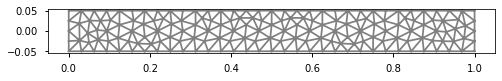

In [31]:
import dolfin
import ufl
import mshr
import numpy as np
import matplotlib.pyplot as plt

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"

plt.style.use('seaborn-notebook')
from slepc_eigensolver import EigenSolver

# ------

# Geometry
nx = 20

Lx, Ly = 1., .1

dim    = 2
degree = 2

p0   = dolfin.Point( 0, -Ly/2)
p1   = dolfin.Point(Lx, +Ly/2)

geom = mshr.Rectangle(p0, p1)
mesh = mshr.generate_mesh(geom, nx)

# -----

# mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(Lx, Ly), nx, ny)
# Mark boundary subdomains
left   = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
right  = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary",Lx=Lx)
bottom = dolfin.CompiledSubDomain("near(x[1], 0) && on_boundary")
top    = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary",Ly=Ly/2)

# Mark facets for Neumann BCs
boundary_indices = {'left'  : 1,
                    'right' : 2,
                    'top'   : 3,
                    'bottom': 4}

boundary_markers = dolfin.MeshFunction("size_t",
                                       mesh    ,
                                       dim  =1 ,
                                       value=0 )

left.mark  (boundary_markers, boundary_indices["left"  ])
right.mark (boundary_markers, boundary_indices["right" ])
top.mark   (boundary_markers, boundary_indices["top"   ])
bottom.mark(boundary_markers, boundary_indices["bottom"])

# Redefine element of area to include information about the markers
ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)
dolfin.plot(mesh)

# ---------

# Save mesh in an XDMF file to open in paraview.

with dolfin.XDMFFile("mesh_functions.xdmf") as f:
    f.write(boundary_markers)
    
V_element = dolfin.VectorElement('CG', ufl.triangle, degree=2,) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")
    
I  = ufl.Identity(2)
F  = ufl.variable(I + ufl.grad(u))  
C  = F.T*F                   
Ic = ufl.tr(C)
J  = ufl.det(F)
E  = 1/2*(C-I)

Y, nu = 1.1E3, .35
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 

psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
#lmbda*ufl.tr(E)**2/2 + mu*ufl.inner(E,E)

# -----

alpha = +0.0
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3
b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "+t * rho_g * sin(alpha)"),
                       t=0, alpha=alpha, rho_g=rho_g, degree=2)

g0 = mu*dolfin.Constant((0.0, 0.0)) 
    
# ---------------

potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(boundary_indices['right'])
bcs = [dolfin.DirichletBC(V, (0., 0.), left)]

residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
problem  = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
solver   = dolfin.NonlinearVariationalSolver(problem)

# -----

neig=8
def stability_monitor(ddE, u, bcs, neig=neig, verbose=True):
    eig_solver = EigenSolver(ddE, u, bcs=bcs)
    ncv, it = eig_solver.solve(neig,verbose=verbose) 
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
    min_eig = min(eigenvalues.real)
    #max_eig = max(eigenvalues.real)
    
    return min_eig
    
stability_monitor(jacobian, u, bcs, neig)

u.interpolate(dolfin.Constant((0., 0.))) # initial guess

# ------------------------------------------------------------
# ------------------------------------------------------------

loads = np.linspace(0., 2., 50)

# ------------------------------------------------------------
# ------------------------------------------------------------

#forces = np.zeros_like(loads)
min_eig = np.zeros_like(loads)
max_eig = np.zeros_like(loads)
displ   = np.zeros_like(loads)
forces  = np.zeros_like(loads)

#file_u = File("results/nonlinear_compression.pvd");

alpha = .1
b0.alpha = +alpha

b0.t=0
for (i, t) in enumerate(loads):
    b0.t = t 
    
    # solve the problem
    solver.solve()
    
    # compute the smallest eigenvalue
    min_eig[i] = stability_monitor(jacobian, u, bcs, neig=2, verbose=False)
    #max_eig[i] = stability_monitor(jacobian, u, bcs, neig, verbose=False)
    
    # end displacement
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly
    print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
    #file_u << (u,t)

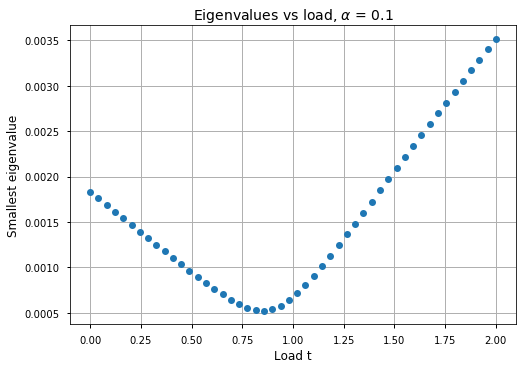

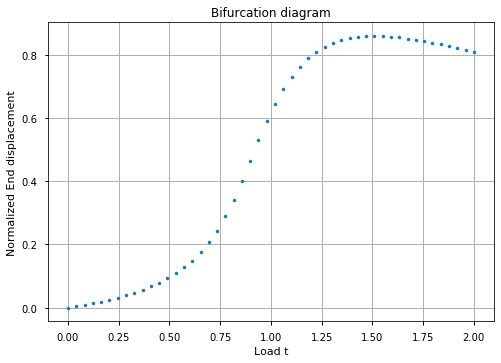

In [33]:
plt.figure(2)
plt.plot(loads, min_eig, "o")
#plt.plot(loads, max_eig, "o", label='max')
plt.grid(True)
plt.xlabel("Load t", fontsize=12)
plt.ylabel("Smallest eigenvalue", fontsize=12)
plt.title(r'Eigenvalues vs load, $\alpha$ = {}'.format(alpha), fontsize=14)
plt.savefig("output/eigenvalues.png")

# --------

plt.figure()
plt.plot(loads, displ / Lx, '.')
plt.ylabel('Normalized End displacement')
plt.xlabel('Load t')
plt.title('Bifurcation diagram')
plt.grid()
plt.show()

We conclude with another method on the fact the stable branches are the one with $\alpha = \pm .1$ while the case $\alpha=0$° is unstable, as one can see looking at eigen-values then negativeness.

**THE END**